In [1]:
!rm -rf

In [2]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.1/872.1 kB 52.8 MB/s eta 0:00:00


In [3]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from shutil import copyfile
import matplotlib.pyplot as plt
from PIL import Image

import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics YOLOv8.2.87 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.9/78.2 GB disk)


In [4]:
home  = os.getcwd()
print(home)

/content


In [5]:
!unzip Football_detection.zip

Archive:  Football_detection.zip
   creating: Football_detection.v7i.yolov8/
   creating: Football_detection.v7i.yolov8/Dataset/
   creating: Football_detection.v7i.yolov8/Dataset/images/
  inflating: Football_detection.v7i.yolov8/Dataset/images/football_mp4-0111_jpg.rf.2362dbb3131665e79e75caad864f27c9.jpg  
  inflating: Football_detection.v7i.yolov8/Dataset/images/football_mp4-0111_jpg.rf.8716230160e638b1c5bd88813ca7a248.jpg  
  inflating: Football_detection.v7i.yolov8/Dataset/images/football_mp4-0111_jpg.rf.d80a03e8936281bafc3c20d36af62218.jpg  
  inflating: Football_detection.v7i.yolov8/Dataset/images/football_mp4-0112_jpg.rf.208192f3af16f2b0fb6a469696e61668.jpg  
  inflating: Football_detection.v7i.yolov8/Dataset/images/football_mp4-0112_jpg.rf.cbf8b713214c6bf8c25ca7fd7a56af24.jpg  
  inflating: Football_detection.v7i.yolov8/Dataset/images/football_mp4-0112_jpg.rf.ef5bd86244016ac9283647e247dbe6be.jpg  
  inflating: Football_detection.v7i.yolov8/Dataset/images/football_mp4-0113_jpg.

In [7]:
!ls

Football_detection  Football_detection.zip


In [8]:
ipaths=[]
tpaths=[]
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        if filename[-4:]=='.jpg':
            ipaths+=[os.path.join(dirname, filename)]
        elif filename[-4:]=='.txt':
            tpaths+=[os.path.join(dirname, filename)]
ipaths=sorted(ipaths)
tpaths=sorted(tpaths)
print(ipaths[0])
print(len(ipaths))

./Football_detection/Dataset/images/football_mp4-0111_jpg.rf.2362dbb3131665e79e75caad864f27c9.jpg
690


In [9]:
boxdata=[]
boxfile=[]
for i in range(len(tpaths)):
    file=tpaths[i]
    boxdata+=[np.loadtxt(file)]
    boxfile+=[file[0:-4].split('/')[-1]]
print(boxdata[0])

[          0     0.71953      0.1375     0.05625    0.089063]


In [10]:
BOX=pd.DataFrame()

for i in range(len(boxdata)):
    if type(boxdata[i][0])==np.float64:
        add=pd.DataFrame([boxdata[i]])
        add[5]=boxfile[i]
        BOX=pd.concat([BOX,add])
    else:
        add=pd.DataFrame(boxdata[i])
        add[5]=boxfile[i]
        BOX=pd.concat([BOX,add])

BOX2=BOX.reset_index(drop=True)
display(BOX2)

,0,1,2,3,4,5
0,0.0,0.719531,0.137500,0.056250,0.089063,football_mp4-0111_jpg.rf.2362dbb3131665e79e75c...
1,0.0,0.707031,0.129688,0.053125,0.087500,football_mp4-0111_jpg.rf.8716230160e638b1c5bd8...
2,0.0,0.895312,0.653125,0.093750,0.064062,football_mp4-0111_jpg.rf.d80a03e8936281bafc3c2...
3,0.0,0.169531,0.300000,0.103125,0.073438,football_mp4-0112_jpg.rf.208192f3af16f2b0fb6a4...
4,0.0,0.626563,0.135156,0.054688,0.093750,football_mp4-0112_jpg.rf.cbf8b713214c6bf8c25ca...
...,...,...,...,...,...,...
685,0.0,0.435156,0.696875,0.026562,0.054688,yt-hhIMMk1fMs8-0018_jpg.rf.c0b5367bc963c3c6bda...
686,0.0,0.318750,0.398438,0.059375,0.035937,yt-hhIMMk1fMs8-0018_jpg.rf.d9e9e5fdbe8ce6fef55...
687,0.0,0.442188,0.610156,0.021875,0.049219,yt-hhIMMk1fMs8-0019_jpg.rf.16c0af36e88c355c2e8...
688,0.0,0.591406,0.584375,0.054688,0.034375,yt-hhIMMk1fMs8-0019_jpg.rf.42c9001e4fe2314f727...


In [11]:
class_map = {0:'football'}

In [12]:
# Directly map all values in the first column to 'football'
BOX2.iloc[:, 0] = 'football'

# Display the modified DataFrame
display(BOX2)

# Display the count of occurrences of each value in the first column
display(BOX2.iloc[:, 0].value_counts())

,0,1,2,3,4,5
0,football,0.719531,0.137500,0.056250,0.089063,football_mp4-0111_jpg.rf.2362dbb3131665e79e75c...
1,football,0.707031,0.129688,0.053125,0.087500,football_mp4-0111_jpg.rf.8716230160e638b1c5bd8...
2,football,0.895312,0.653125,0.093750,0.064062,football_mp4-0111_jpg.rf.d80a03e8936281bafc3c2...
3,football,0.169531,0.300000,0.103125,0.073438,football_mp4-0112_jpg.rf.208192f3af16f2b0fb6a4...
4,football,0.626563,0.135156,0.054688,0.093750,football_mp4-0112_jpg.rf.cbf8b713214c6bf8c25ca...
...,...,...,...,...,...,...
685,football,0.435156,0.696875,0.026562,0.054688,yt-hhIMMk1fMs8-0018_jpg.rf.c0b5367bc963c3c6bda...
686,football,0.318750,0.398438,0.059375,0.035937,yt-hhIMMk1fMs8-0018_jpg.rf.d9e9e5fdbe8ce6fef55...
687,football,0.442188,0.610156,0.021875,0.049219,yt-hhIMMk1fMs8-0019_jpg.rf.16c0af36e88c355c2e8...
688,football,0.591406,0.584375,0.054688,0.034375,yt-hhIMMk1fMs8-0019_jpg.rf.42c9001e4fe2314f727...


,count
0,
football,690


In [13]:
def draw_box(n0):

    ipath=ipaths[n0]
    image=cv2.imread(ipath)
    H,W=image.shape[0],image.shape[1]
    file=ipath[0:-4].split('/')[-1]

    if BOX2[BOX2[5]==file] is not None:
        box=BOX2[BOX2[5]==file]
        box=box.reset_index(drop=True)

        for i in range(len(box)):
            label=box.iloc[i,0]
            x=box.iloc[i,1]
            y=box.iloc[i,2]
            w=box.iloc[i,3]
            h=box.iloc[i,4]
            x0=((x-w/2)*W).astype(int)
            y0=((y-h/2)*H).astype(int)
            x1=((x+w/2)*W).astype(int)
            y1=((y+h/2)*H).astype(int)

            if label=='football':
                cv2.rectangle(image,(x0,y0),(x1,y1),(0,0,255),5) #blue


    return image

In [14]:
images1=[]
for i in tqdm(range(len(ipaths))):
    images1+=[draw_box(i)]

100%|██████████| 690/690 [00:02<00:00, 269.05it/s]


In [15]:
os.makedirs('datasets', exist_ok=True)
os.makedirs('datasets/train', exist_ok=True)
os.makedirs('datasets/valid', exist_ok=True)
os.makedirs('datasets/test', exist_ok=True)

In [16]:
!ls

datasets  Football_detection  Football_detection.zip


In [17]:
for i in range(len(ipaths)):
    ipath=ipaths[i]
    ifile=ipath.split('/')[-1]
    tpath=tpaths[i]
    tfile=tpath.split('/')[-1]
    if i%2==0:
        copyfile(ipath, f'/content/datasets/train/{ifile}')
        copyfile(tpath, f'/content/datasets/train/{tfile}')
    elif i%3==1:
        copyfile(ipath, f'/content/datasets/valid/{ifile}')
        copyfile(tpath, f'/content/datasets/valid/{tfile}')
    else:
        copyfile(ipath, f'/content/datasets/test/{ifile}')

In [18]:
import yaml

football_yaml = dict(
    train ='train',
    val ='valid',
    test='test',
    nc =1,
    names =['football']
)

with open('football.yaml', 'w') as outfile:
    yaml.dump(football_yaml, outfile, default_flow_style=True)

%cat football.yaml

{names: [football], nc: 1, test: test, train: train, val: valid}


In [19]:
!yolo task=detect mode=train model=yolov8s.pt data=football.yaml epochs=30 imgsz=640 plots=True

100% 21.5M/21.5M [00:00<00:00, 42.8MB/s]
Ultralytics YOLOv8.2.87 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=football.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels

In [20]:
print(os.getcwd())
!ls runs/detect/train

/content
args.yaml					    R_curve.png		val_batch0_labels.jpg
confusion_matrix_normalized.png			    results.csv		val_batch0_pred.jpg
confusion_matrix.png				    results.png		val_batch1_labels.jpg
events.out.tfevents.1725424005.40fbf70aa1c9.3359.0  train_batch0.jpg	val_batch1_pred.jpg
F1_curve.png					    train_batch1.jpg	val_batch2_labels.jpg
labels_correlogram.jpg				    train_batch2.jpg	val_batch2_pred.jpg
labels.jpg					    train_batch440.jpg	weights
P_curve.png					    train_batch441.jpg
PR_curve.png					    train_batch442.jpg


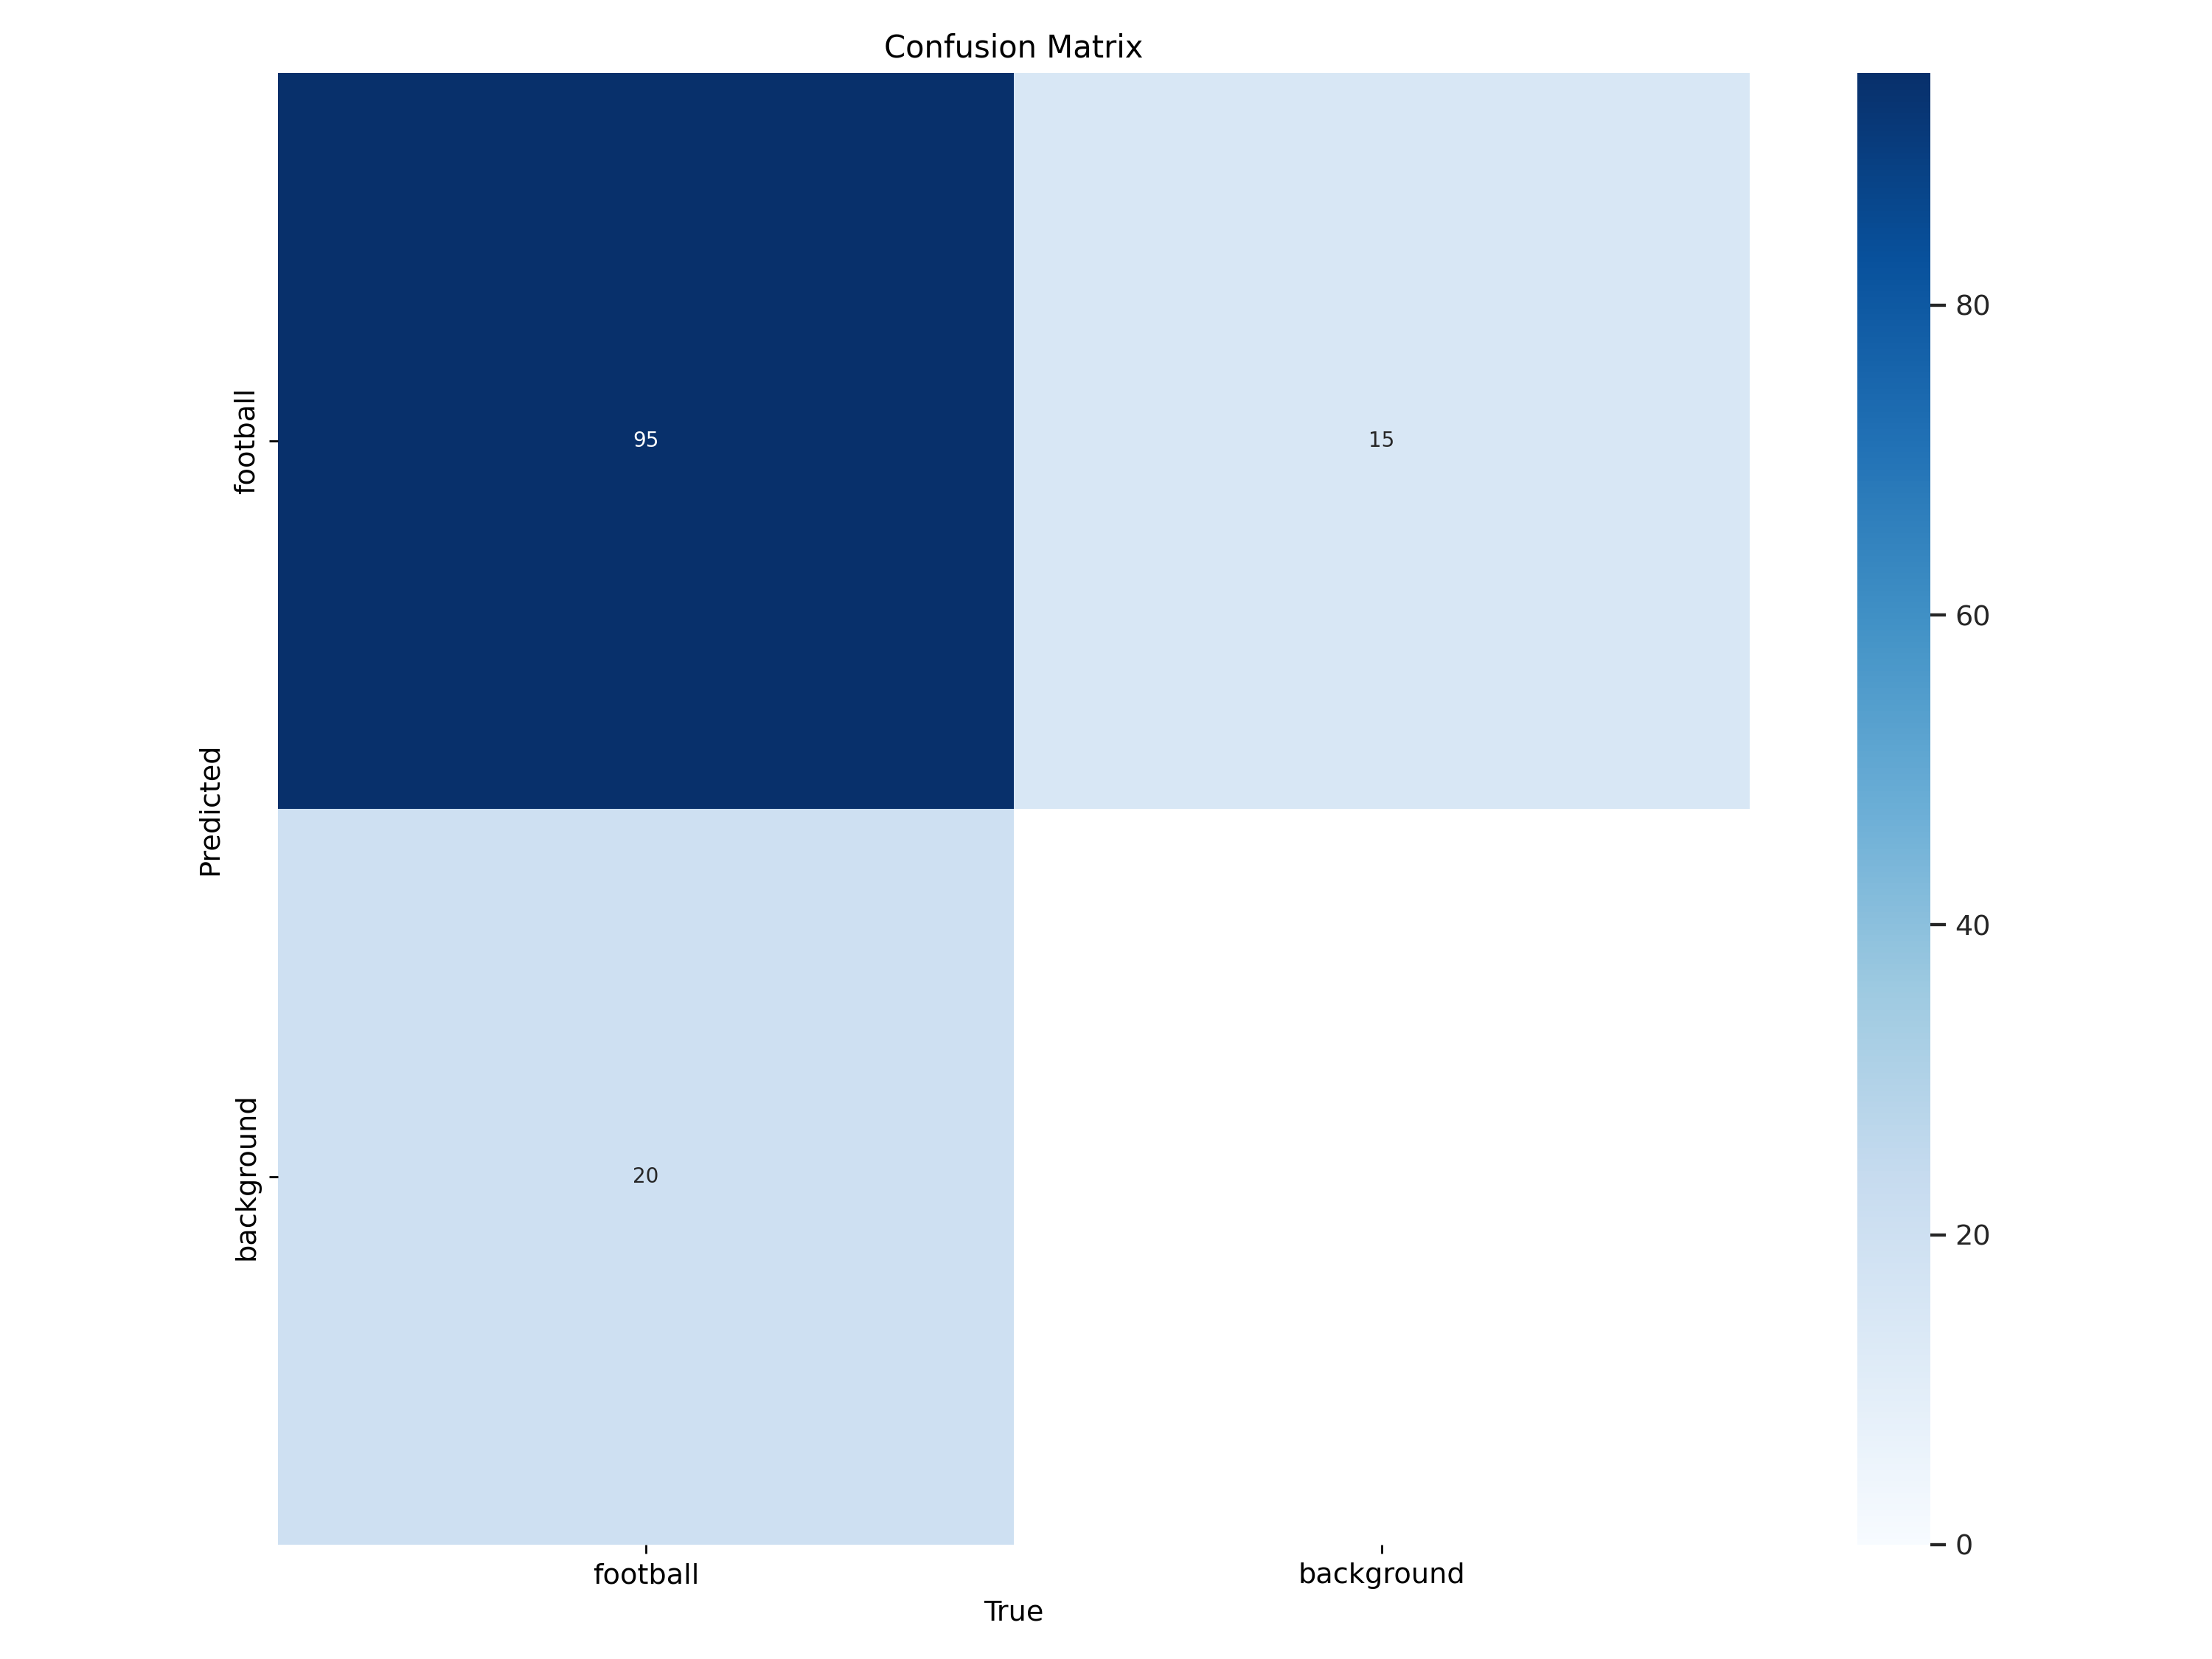

In [21]:
from IPython.display import Image
Image(filename=f'runs/detect/train/confusion_matrix.png', width=600)

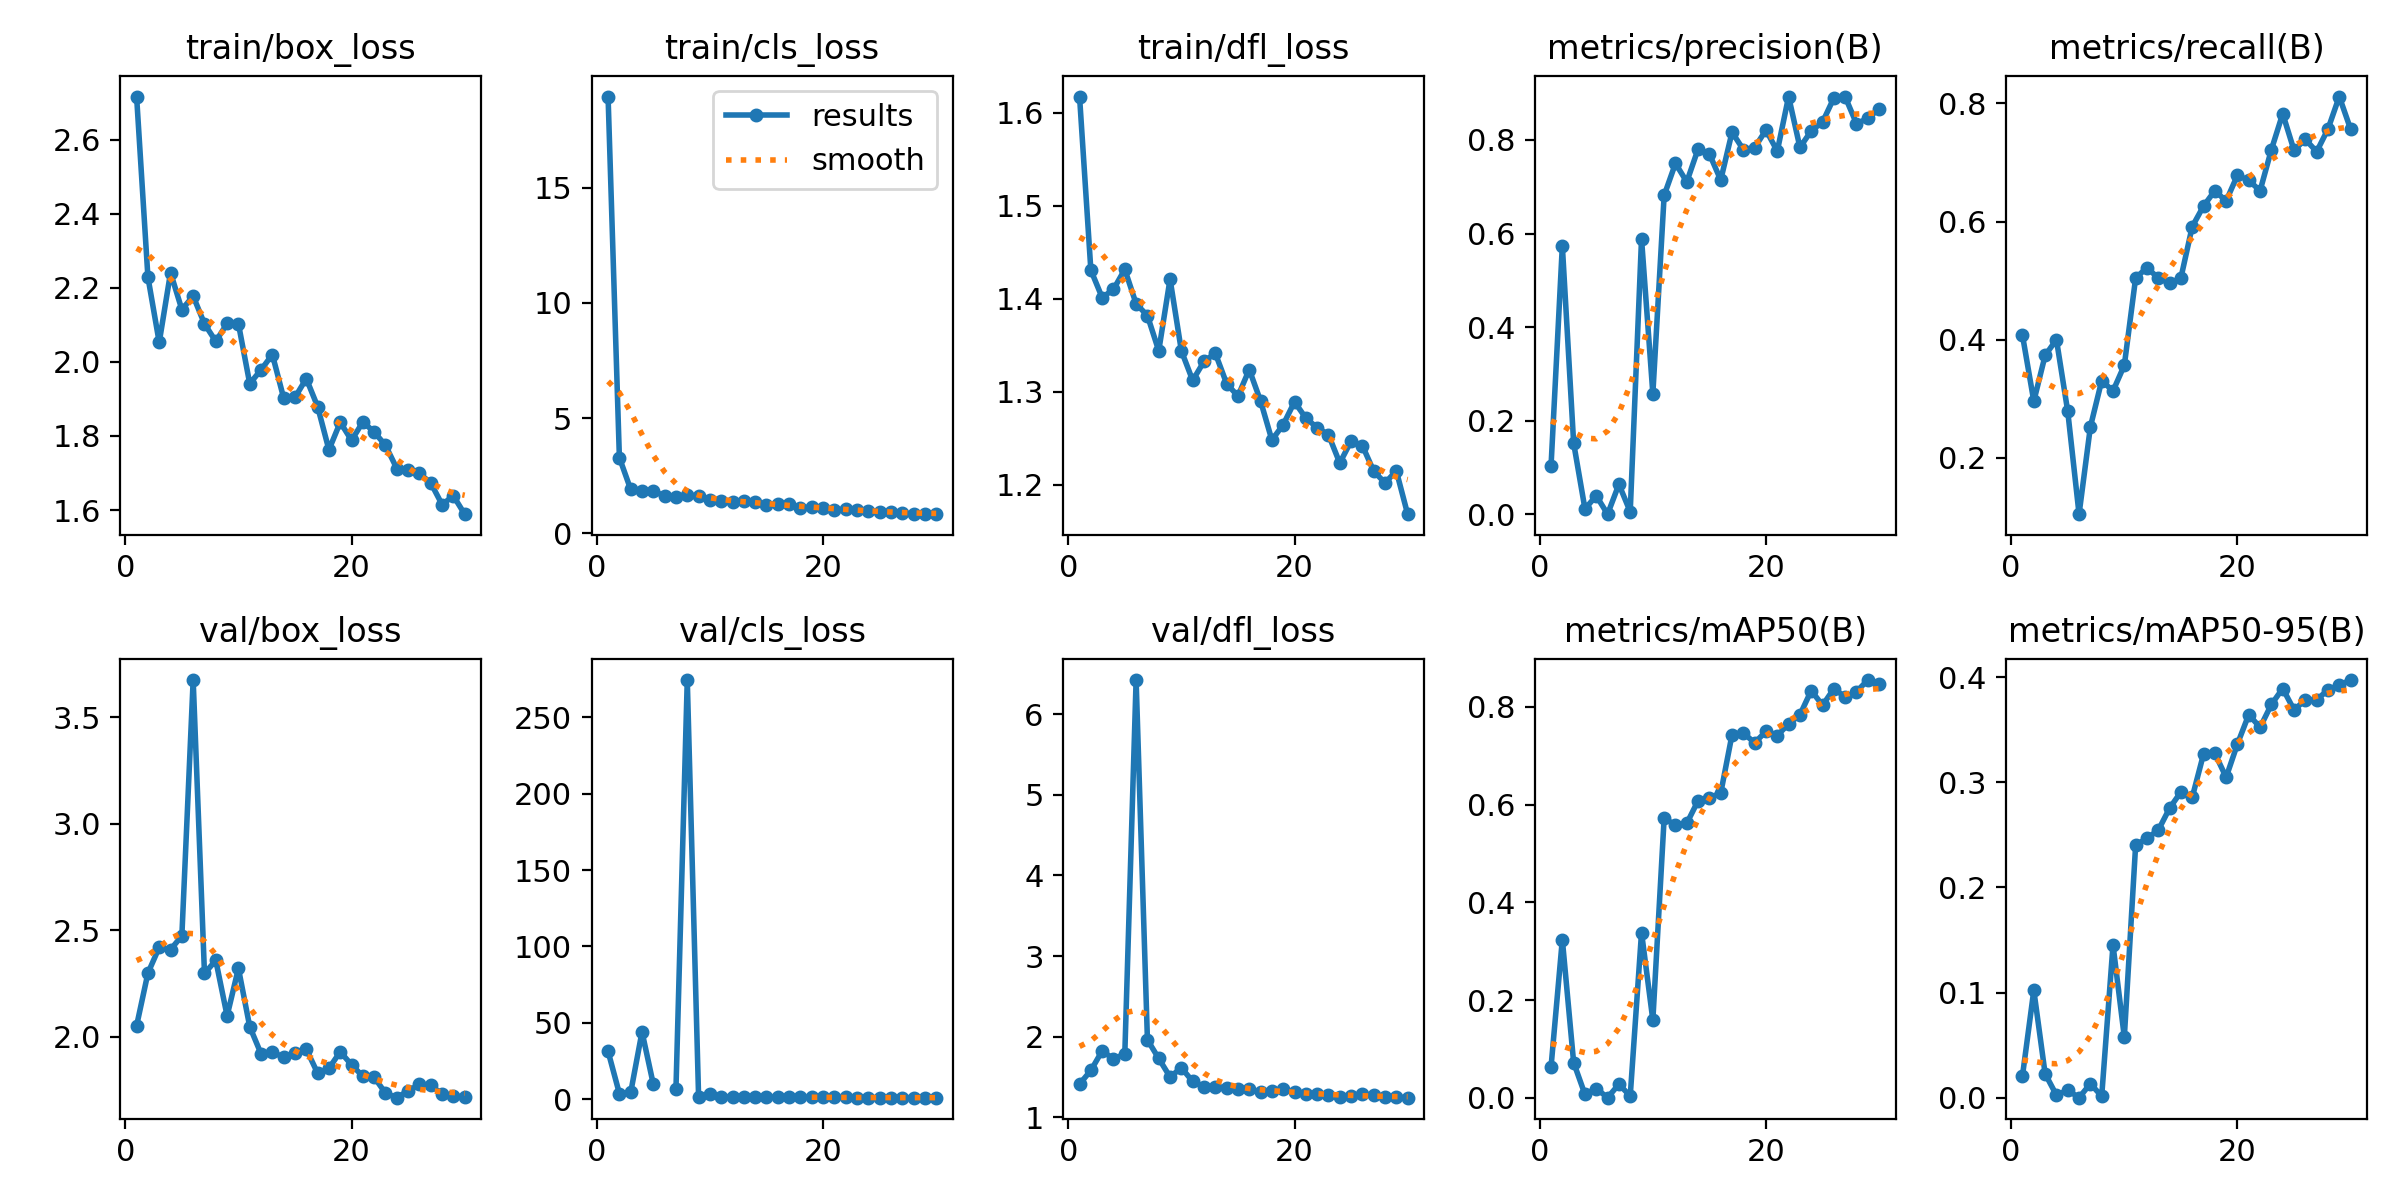

In [22]:
Image(filename=f'runs/detect/train/results.png', width=600)

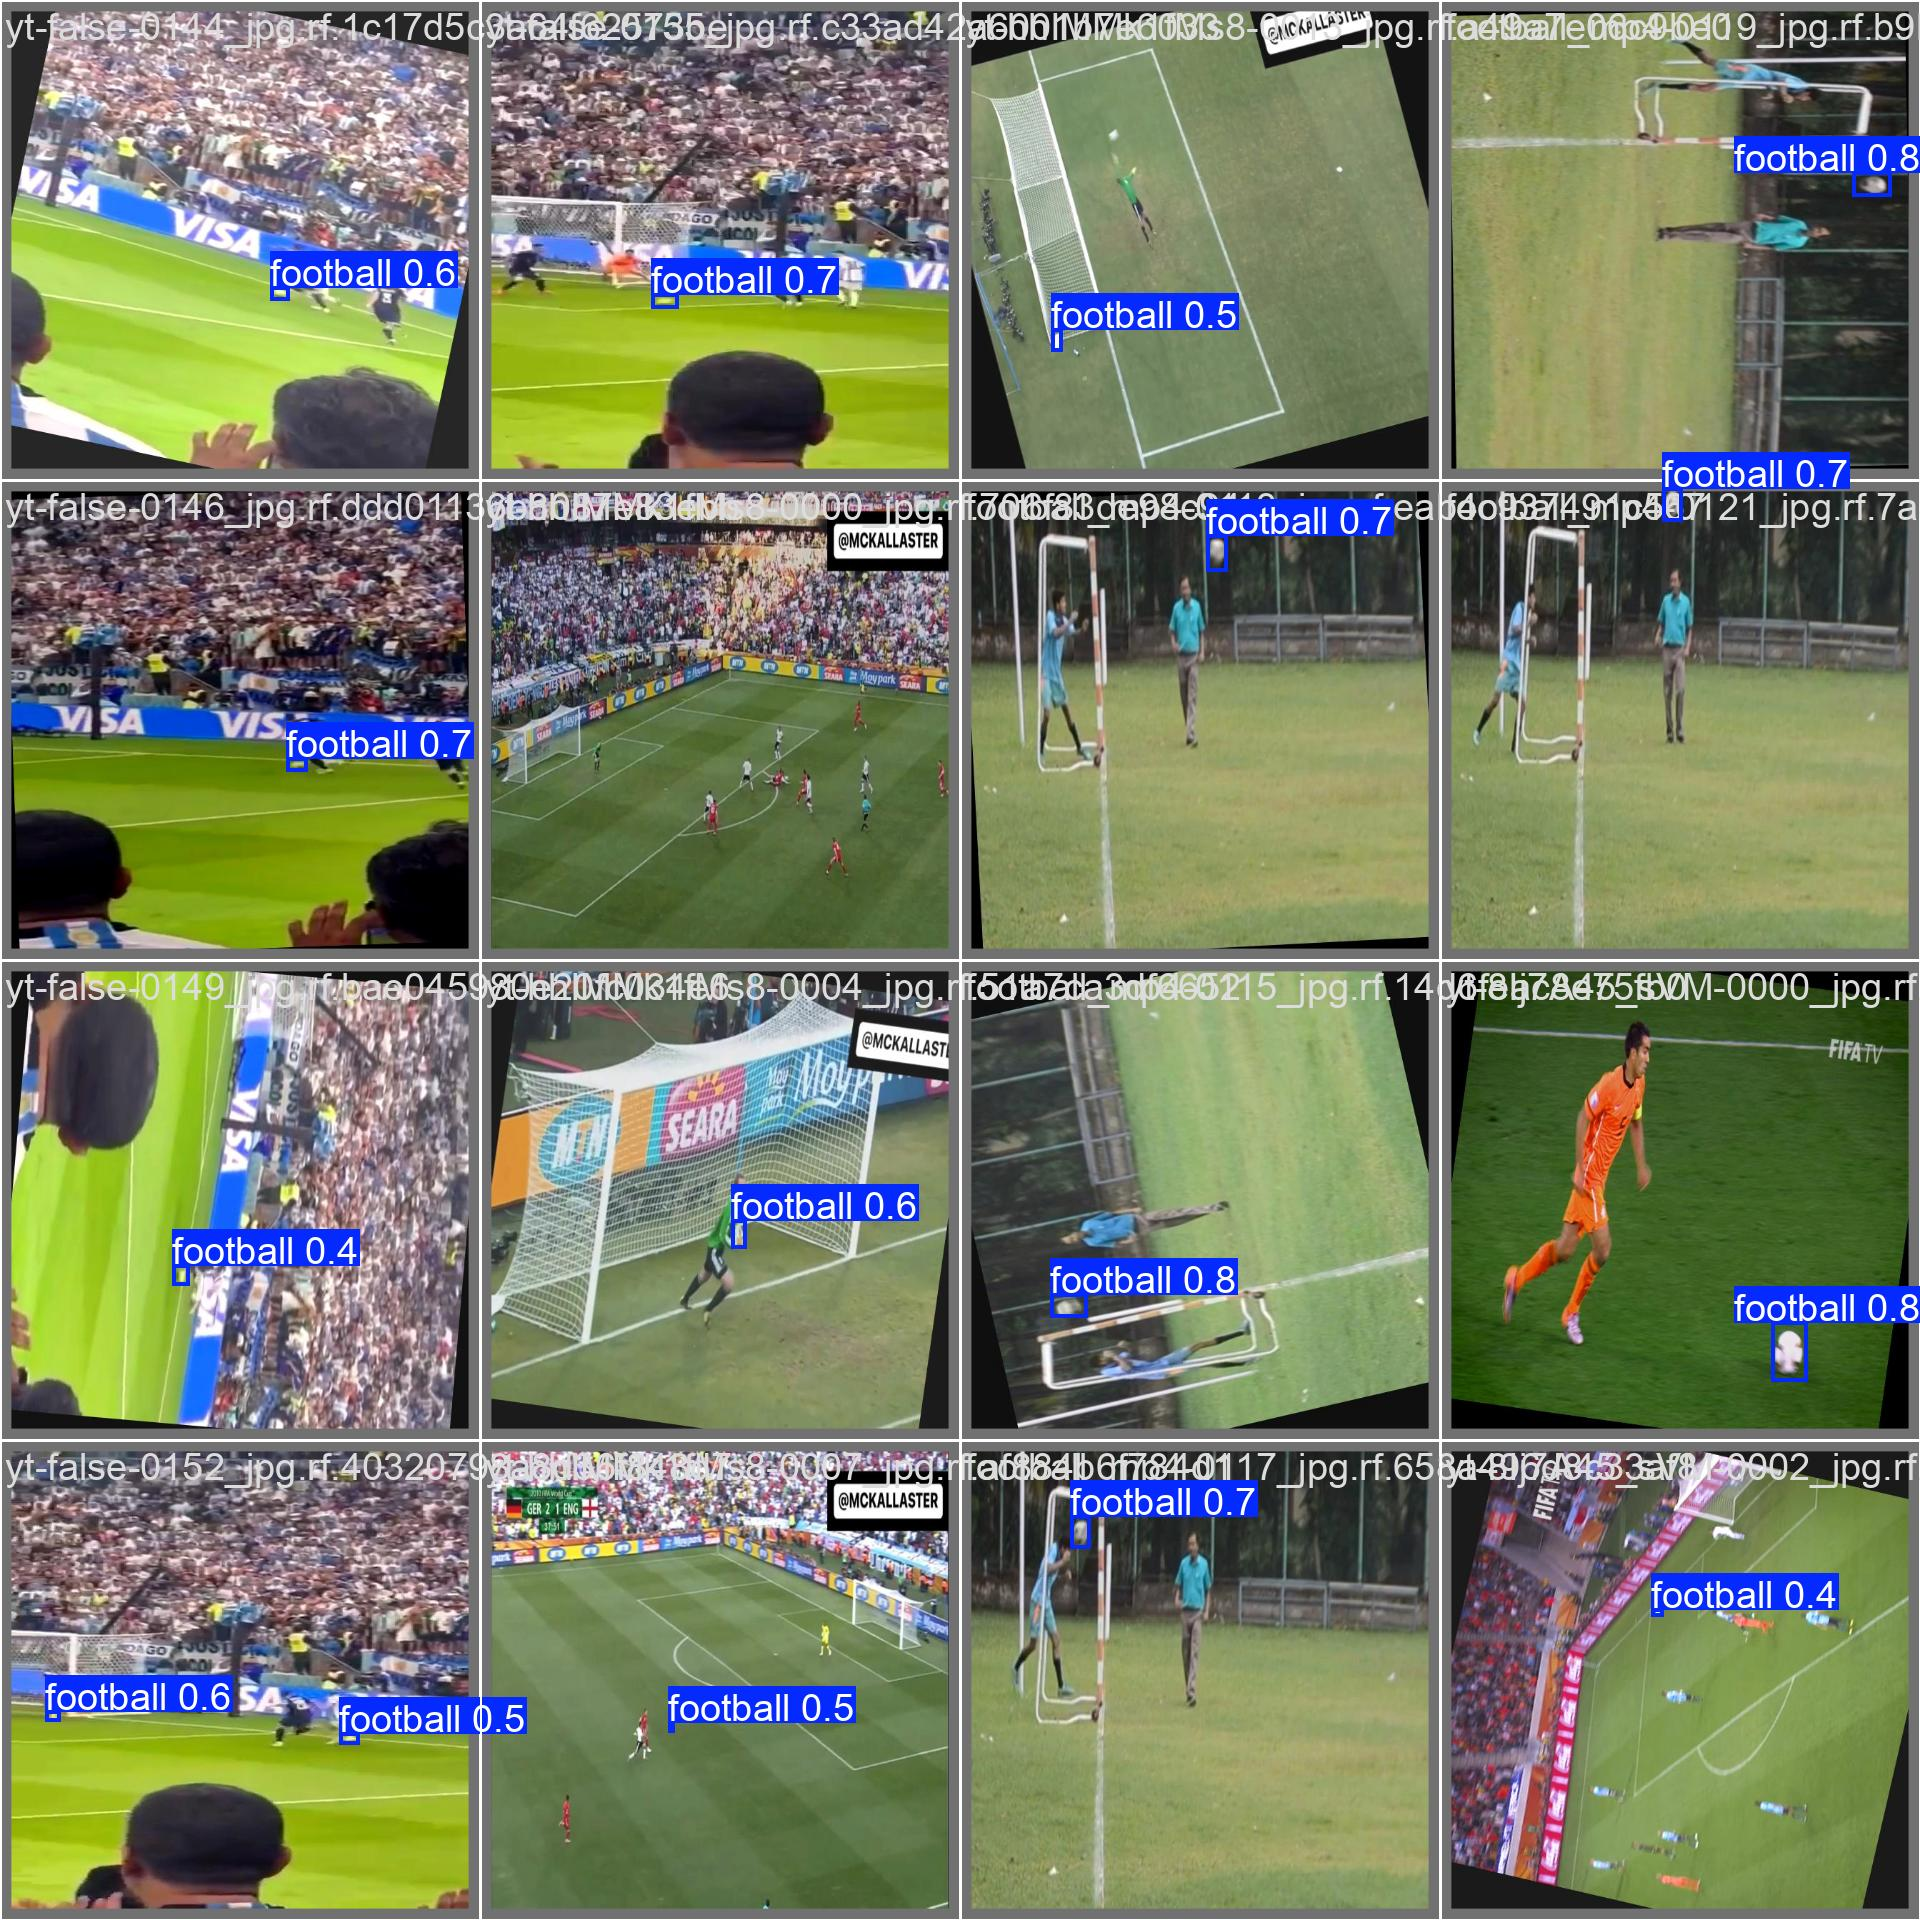

In [23]:
Image(filename=f'runs/detect/train/val_batch0_pred.jpg', width=600)

In [24]:
!yolo task=detect mode=val model=runs/detect/train/weights/best.pt data=football.yaml

Ultralytics YOLOv8.2.87 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/datasets/valid.cache... 115 images, 0 backgrounds, 0 corrupt: 100% 115/115 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 8/8 [00:03<00:00,  2.04it/s]
                   all        115        115      0.874      0.765      0.856      0.396
Speed: 2.5ms preprocess, 10.8ms inference, 0.0ms loss, 7.0ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


In [25]:
!yolo task=detect mode=predict model=runs/detect/train/weights/best.pt conf=0.25 source= datasets/test save=True

Ultralytics YOLOv8.2.87 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs

image 1/230 /content/datasets/test/football_mp4-0112_jpg.rf.208192f3af16f2b0fb6a469696e61668.jpg: 640x640 1 football, 16.2ms
image 2/230 /content/datasets/test/football_mp4-0112_jpg.rf.ef5bd86244016ac9283647e247dbe6be.jpg: 640x640 1 football, 16.3ms
image 3/230 /content/datasets/test/football_mp4-0114_jpg.rf.0044f6a76c72d8eeb25de33dc3ec3fb6.jpg: 640x640 1 football, 16.2ms
image 4/230 /content/datasets/test/football_mp4-0114_jpg.rf.f315484d20e8a62e92b03bb9d2a27d9f.jpg: 640x640 1 football, 16.2ms
image 5/230 /content/datasets/test/football_mp4-0116_jpg.rf.34f347d9e2348e078a5b25302aea885f.jpg: 640x640 (no detections), 16.2ms
image 6/230 /content/datasets/test/football_mp4-0116_jpg.rf.f8fd664683427beb7be526f5ad237114.jpg: 640x640 (no detections), 16.2ms
image 7/230 /content/datasets/test/football_mp4-0118_jpg.rf.372aa4f0c

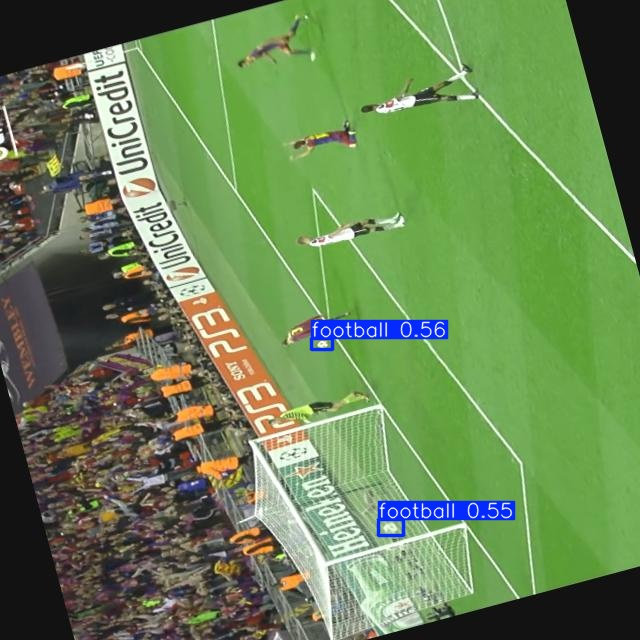

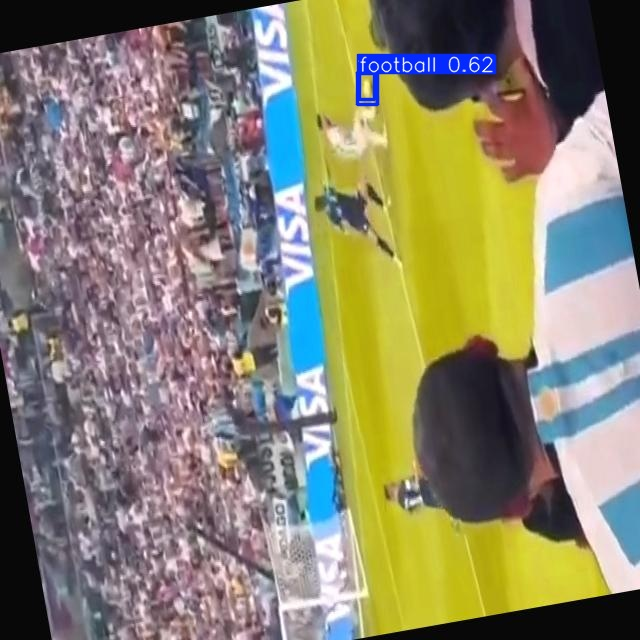

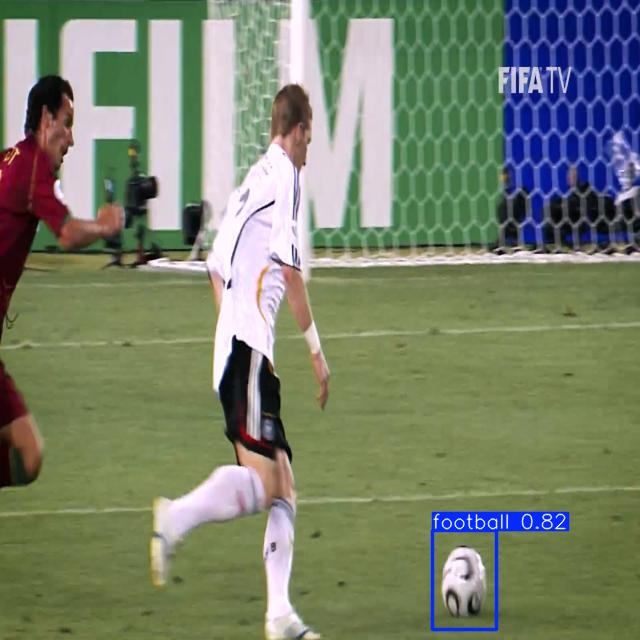

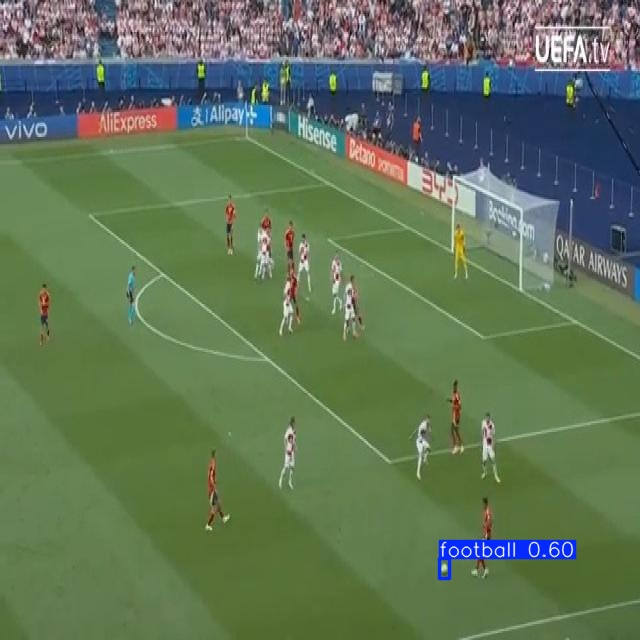

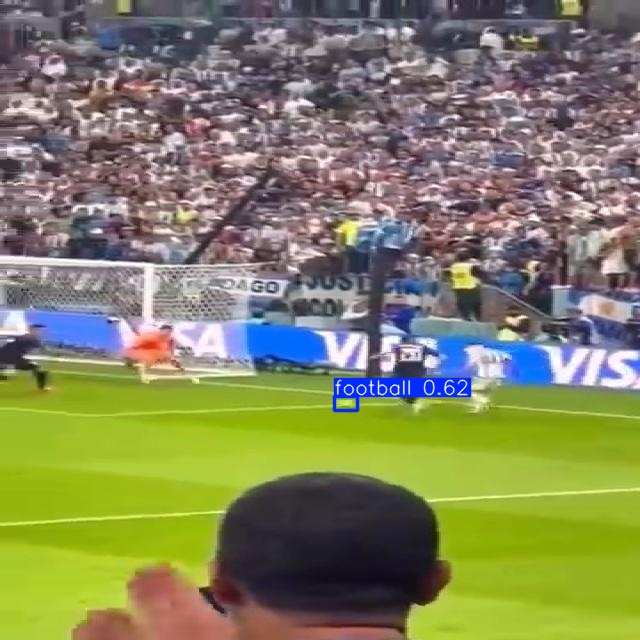

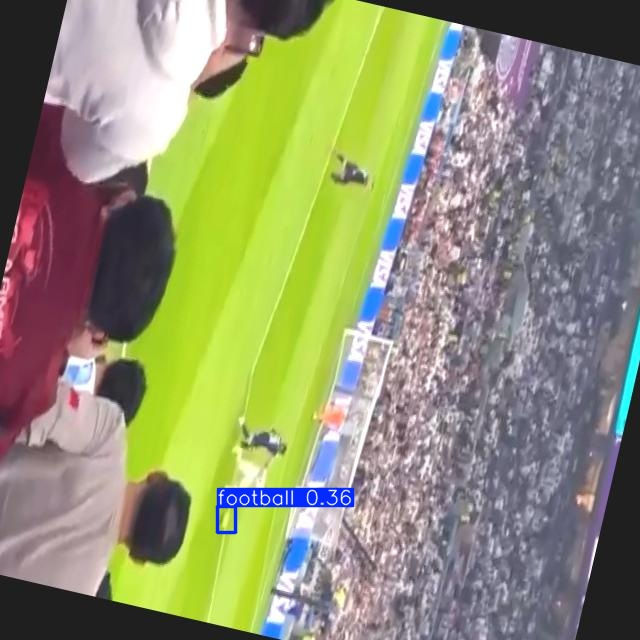

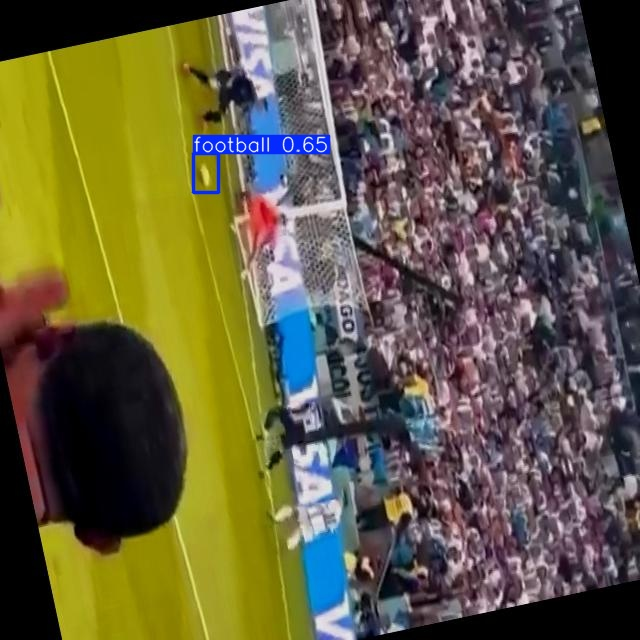

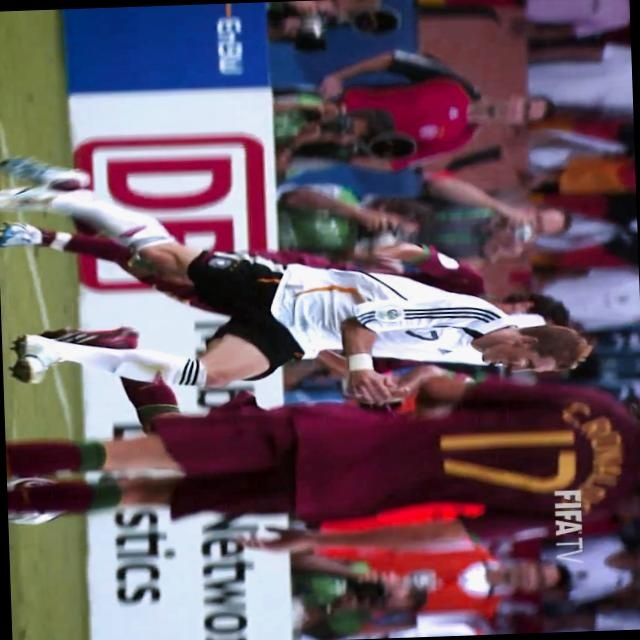

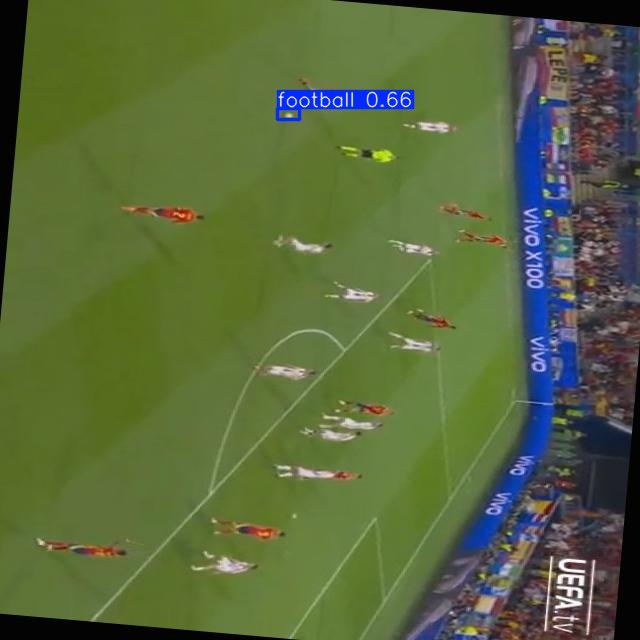

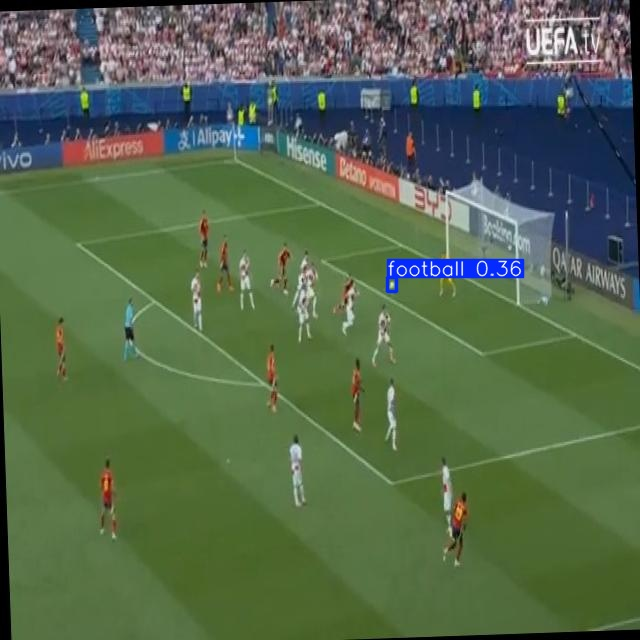

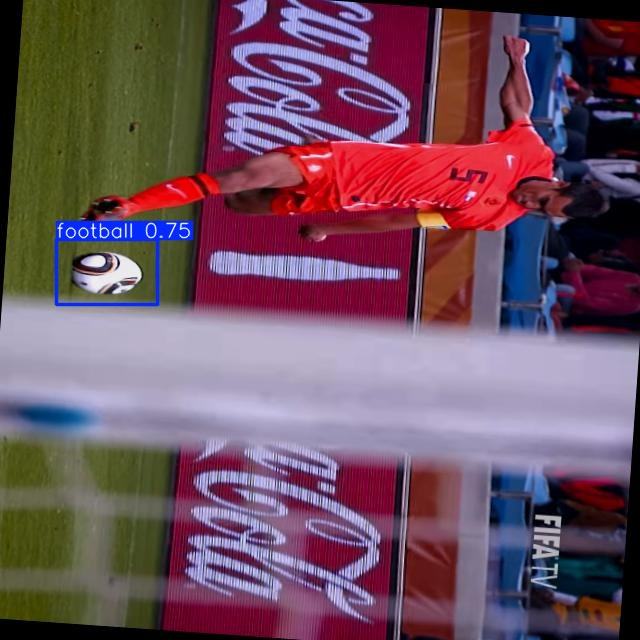

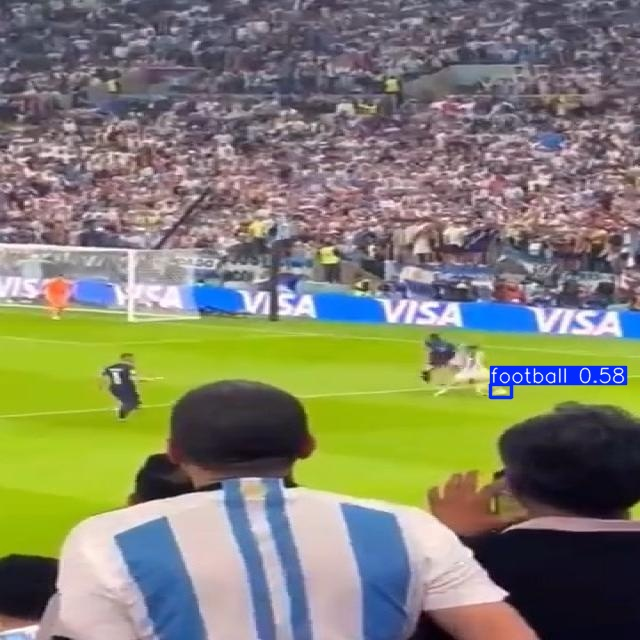

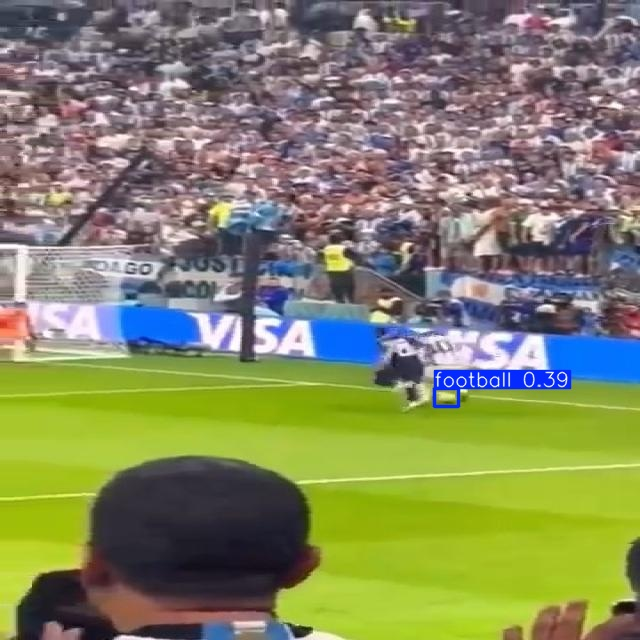

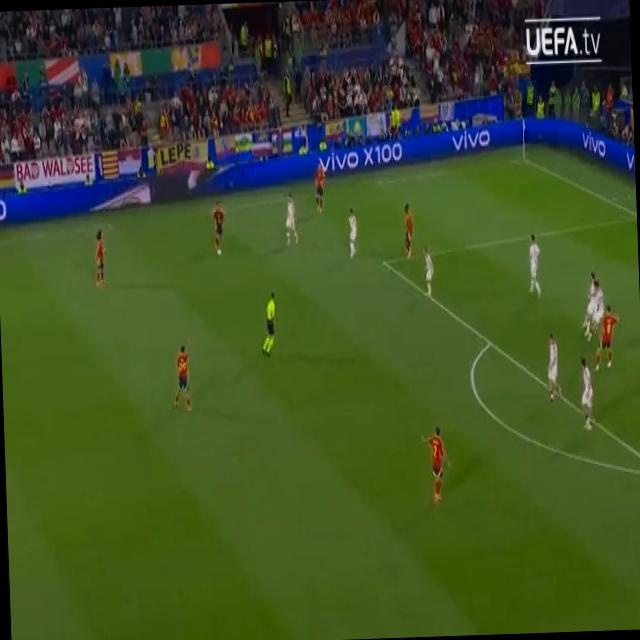

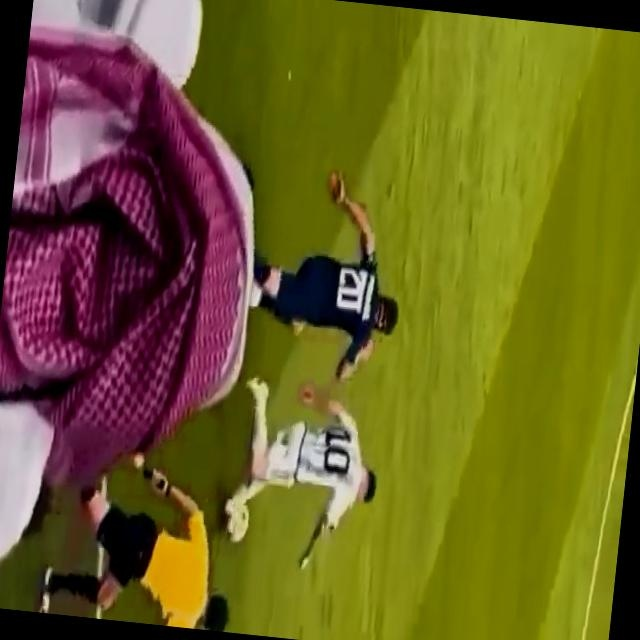

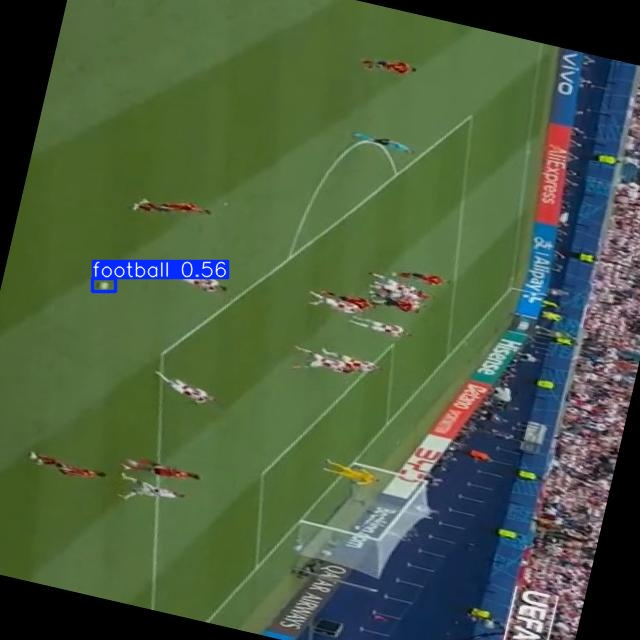

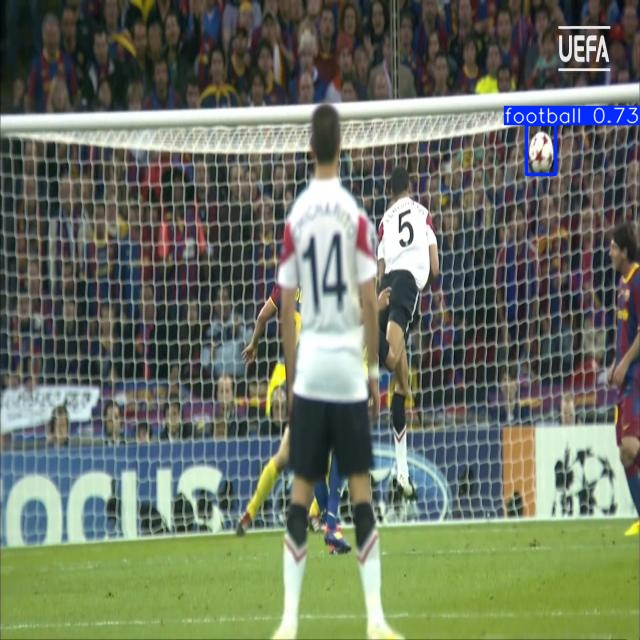

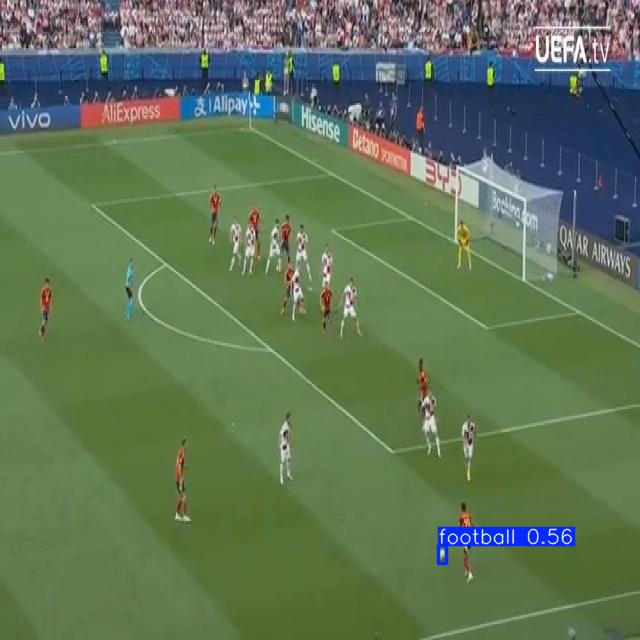

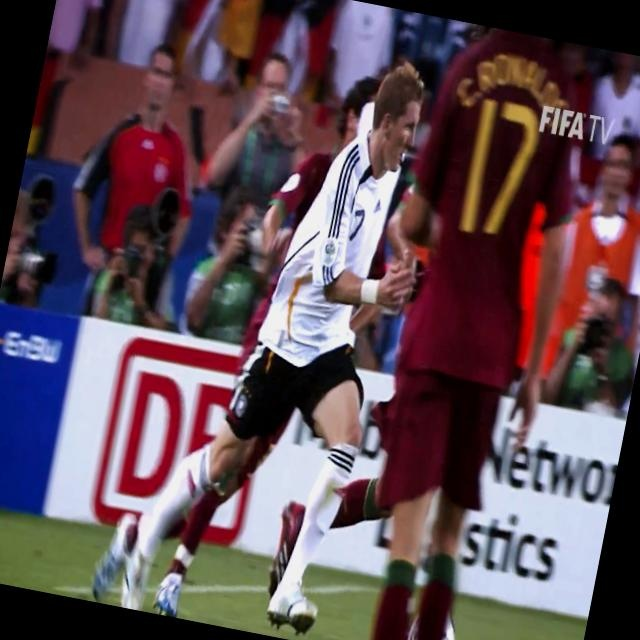

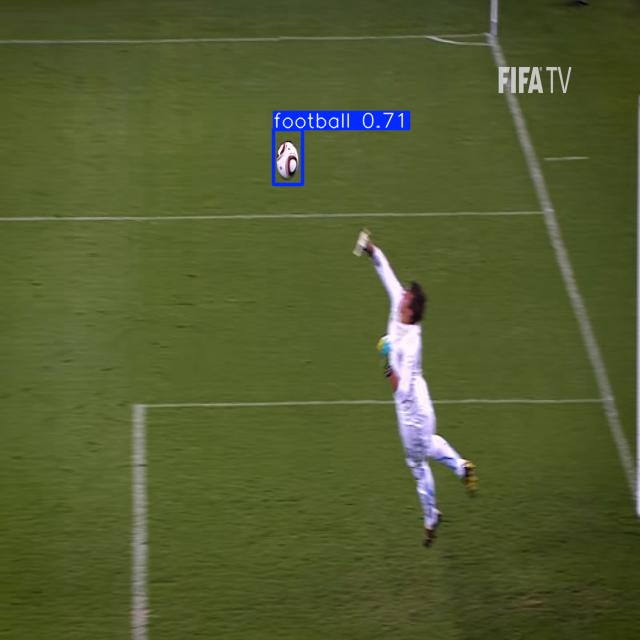

In [44]:
import glob
from IPython.display import Image, display

# Define the base path where the folders are located
base_path = 'runs/detect/'

# List all directories that start with 'predict' in the base path
subfolders = [os.path.join(base_path, d) for d in os.listdir(base_path)
              if os.path.isdir(os.path.join(base_path, d)) and d.startswith('predict')]

# Find the latest folder by modification time
latest_folder = max(subfolders, key=os.path.getmtime)

image_paths = glob.glob(f'{latest_folder}/*.jpg')[:20]

# Display each image
for image_path in image_paths:
    display(Image(filename=image_path, width=600))
    print("\n")

In [47]:
Model = "runs/detect/train/weights/best.pt"

In [48]:
!yolo task=detect mode=predict model={Model} conf=0.25 source="/content/Screenshot 2024-09-04 102530.png" save=True project="/content/predictedImages"


Ultralytics YOLOv8.2.87 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs

image 1/1 /content/Screenshot 2024-09-04 102530.png: 448x640 1 football, 46.5ms
Speed: 4.0ms preprocess, 46.5ms inference, 611.8ms postprocess per image at shape (1, 3, 448, 640)
Results saved to /content/predictedImages/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


In [49]:
!yolo task=detect mode=predict model={Model} conf=0.25 source="/content/Screenshot 2024-09-04 111117.png" save=True project="/content/predictedImages"


Ultralytics YOLOv8.2.87 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs

image 1/1 /content/Screenshot 2024-09-04 111117.png: 480x640 1 football, 39.8ms
Speed: 4.7ms preprocess, 39.8ms inference, 538.2ms postprocess per image at shape (1, 3, 480, 640)
Results saved to /content/predictedImages/predict2
💡 Learn more at https://docs.ultralytics.com/modes/predict


In [50]:
!yolo task=detect mode=predict model={Model} conf=0.25 source="/content/Screenshot 2024-09-04 111524.png" save=True project="/content/predictedImages"


Ultralytics YOLOv8.2.87 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs

image 1/1 /content/Screenshot 2024-09-04 111524.png: 512x640 1 football, 40.8ms
Speed: 5.2ms preprocess, 40.8ms inference, 607.3ms postprocess per image at shape (1, 3, 512, 640)
Results saved to /content/predictedImages/predict3
💡 Learn more at https://docs.ultralytics.com/modes/predict
